## Multi Armed Bandits

### Prasanth Dwadasi

![Outfits](assignment1/What-To-Wear-In-October-4-Outfit-Ideas.png "Outfits")

We are selecting from five outfits each with a different happiness index ranging from 0 to 1


White Shirt,Brown Pant = 0.6

White Shirt,Black Pant = 0.9

Blue Shirt,Brown Pant = 0.5

Blue Shirt,Black Pant = 0.3

Grey Hoodie,Track Pant = 0.7

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    
    if arm_count > 5:
        self.thetas = np.random.uniform(0,1,self.arm_count)
    else:
        self.thetas = np.asarray([0.6,0.9,0.5,0.3,0.7])
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [88]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

class RandomSamp():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        
    @staticmethod
    def name():
        return 'random'
    
    def get_action(self):
        """ Generating random samples between 0 and 1 using uniform distribution"""
        theta = np.random.uniform(0,1,self.arm_count)
        return theta.argmax()
    
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

In [89]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

In [90]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [91]:

def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson,RandomSamp]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

#### Q1) Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling?
<br>
The hyperparameters that plays a crucial role in Thompson sampling is the parameter value alpha and beta from the beta distribution.But we cannot choose them so the hyperparamter we can use is number of iterations <br>
For e-greedy algorithm the important hyperparameter is the value of epsilon, depending on the value of epsilon, the algorithm chooses total explorations.<br>
For UBC, the most important hyperparameter is the constant value c in the below equation.<br>
<br>
$$A_t = argmax_a[Q_t(a) + c\sqrt{\frac{ln t}{N_t(a)}}]$$
<br>
In case of Random Sampling, on each turn a random arm is pulled with equal probability among all the arms. Hence there is no parameter that controls the decision of Random Sampling


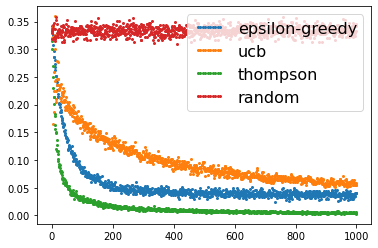

In [62]:
# Experiment 1
arm_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

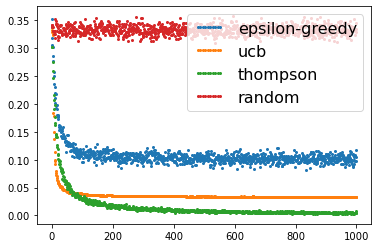

In [63]:
# Experiment 2
arm_count = 5 # number of arms in bandit
epsilon = 0.3
ucb_c = 0.1
stationary=True
experiment(arm_count)

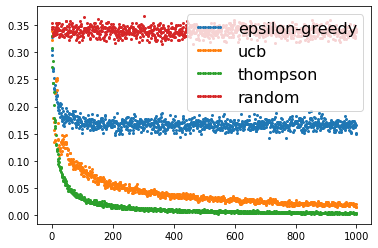

In [64]:
# Experiment 3
arm_count = 5 # number of arms in bandit
epsilon = 0.5
ucb_c = 1
stationary=True
experiment(arm_count)

We can observe from experiments 1,2 and 3 as we increase epsilon the final regret we achieve decreases and for ucb the the lesser the c value the less it explores and the faster it converges.

#### Q2) How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? 

In this setting, we increase the number of actions from 10 to 200, leaving the other parameters equal to our baseline. The $\epsilon$-greedy agent barely budges in its learning pattern when compared to the baseline. The Thompson agent very slowly, but surely, decreases regret to eventually outperform $\epsilon$-greedy around step 700, another vote of confidence for Thompson. On the other hand, UCB is drastically unstable and diverges. This behaviour is not only due to the increase in action space, but due to the fact that the Bernouilli reward probabilities are so close to each other. Recall that regret is calculated as the difference between the optimal $\theta_k$ and the action $\hat{\theta_k}$.Since the true $\theta_k$ are sampled from a uniform distribution, they are evenly spread between 0 and 1.  The greedy algorithm need only sample a few values and has a high probability of its most favourable action's estimated reward probability being close to the true optimal reward probability, ensuring it a low regret, even if it never chooses the optimal action. Thompson and UCB, on the other hand, with their emphasis on exploration, give a high premium to exploring actions not yet seen. Since there are so many actions, and since the mean rewards are evenly distributed between 0 and 1, there is a high cost of constantly exploring actions with rewards close to 0. Noticeably, the Thompson algorithm is incredibly stable across time, despite the large action space. Due to its sampling nature, it has a lower probability than UCB of constantly taking suboptimal actions.

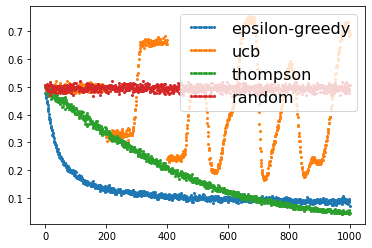

In [75]:
# Experiment 4
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

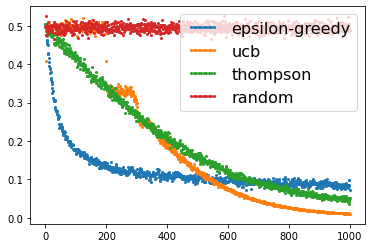

In [74]:
# Experiment 5
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count)

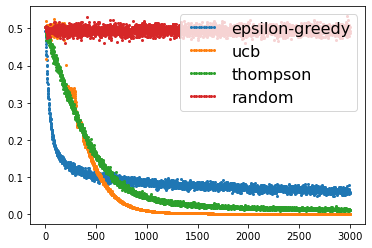

In [76]:
# Experiment 6
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)

#### Q3) How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? 

We now set the environment to being non-stationary. Actually, after every 100 steps, the bandit resamples the action Bernouilli parameters. This places special emphasis on exploration. An algorithm that converges to an action and does not emphasize exploration will perform quite poorly as the true reward distribution changes over time. Below we see a clear jump in regret every time the true bandit parameters are resampled (every 100 steps). While the $\epsilon$-greedy and Thompson's regret quickly decrease, on average they increase over time. On the other hand, UCB reacts much more quickly to the bandit non-stationarity, and actually continues to improve in regret over time, no doubt due to its higher emphasis on exploration. We confirm this in the next experiment.

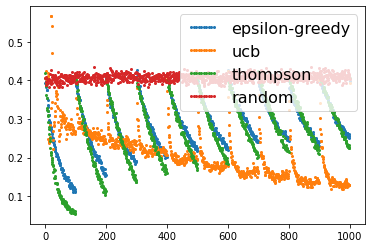

In [95]:
# Experiment 7
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

We now set UCB's _c_ parameter to 0.1 as we did in Experiment 2. Due to Experiment 2's setup, we concluded a greedier version of UCB would perform better in that setup, which it did. In the current setup, we can observe that the greedy UCB performs quite poorly and much like the other algorithms. 

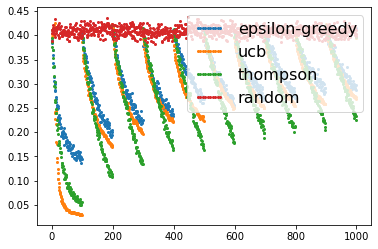

In [99]:
# Experiment 8
arm_count = 10 # number of arms in bandit
epsilon = 0.3
ucb_c = 0.1
stationary=False
experiment(arm_count)

#### Q4) When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points) 

For each model, there are 10000 rounds and 1000 simulations. As shown in the graph below, Thompson and UCB closely converge when the timesteps are increased to 10000. As we can see, Thompson sampling performs much better than the other models. Also, UCB catch up to ε-greedy at around timesteps 3000. In term of exploration-exploitation tradeoff, for the ε-greedy strategy, it is necessary to adjust the hyperparameters to tradeoff exploration and exploitation. But this is not an ideal method because it may be difficult to adjust. The UCB pick the arm that has the maximum value at the upper confidence bound to balance exploration and exploitation. For Thompson Sampling, we can see that it performs efficient exploration, quickly ruling out fewer promising arms.




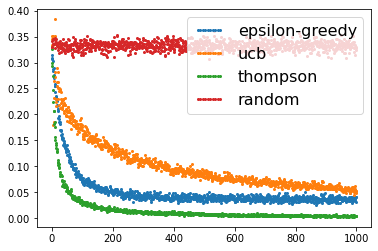

In [67]:
# Experiment 9
arm_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

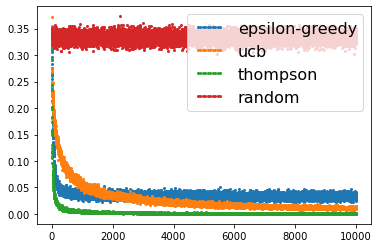

In [68]:
# Experiment 10
arm_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count,timesteps=10000, simulations=1000)

#### Q5) How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. 


When an action is performed, it either succeeds or fails. The agent does not know the success probabilities, but they are fixed over time, so they can be learned through experimentation. To maximize the number of successes, the regret value should be minimized over an entire timestep.

In Thompson Sampling model, it tends to converge, and the regret value is already close to 0.0 after 300 timesteps. In ε-greedy model, it is difficult to see progress after 400 timesteps, and the regret value remains between 0.0 and 0.1 until the end. In UCB model has been slow to reduce regret, it was not lower than 0.1 before the end.
In Epsilon greedy the best value will be know after 400 explorations and from then it will start exploiting.
There is nothing to remeber in random sampling

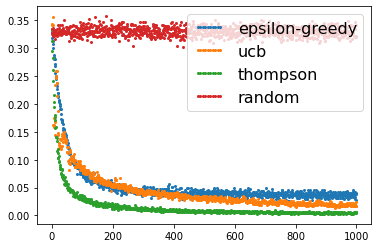

In [66]:
# Experiment 11
arm_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 1
stationary=True
experiment(arm_count)

#### Q6) Thompson Sampling with non-Beta distribution? Modify the Thompson Sampling to run with a Different Distritbution?

We are using Gaussina distribution in place of beta distribution. And here are conversion for mean and std from a and b

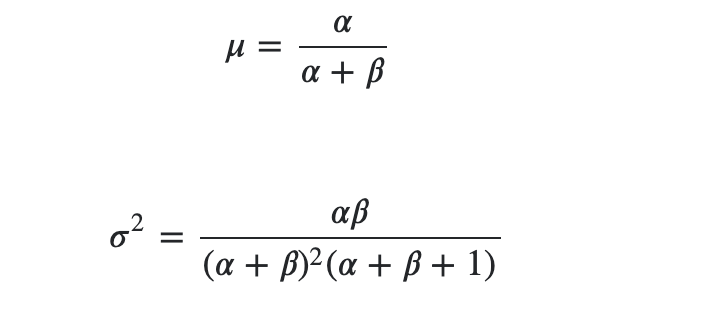






In [55]:
import math
class ThompsonSampling_Normal():
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
    self.mu = np.ones(self.arm_count)
    self.sigma = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward
    self.mu = self.alpha / (self.alpha + self.beta)
    self.sigma = (self.alpha * self.beta)/((self.alpha + self.beta)**2 * (self.alpha + self.beta +1))

  @staticmethod
  def name():
    return 'thompson_normal'
  
  def get_action(self):
    theta = np.random.normal(self.mu, self.sigma)
    return theta.argmax()

In [65]:
def experiment_gaussian_added(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson,RandomSamp,ThompsonSampling_Normal]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

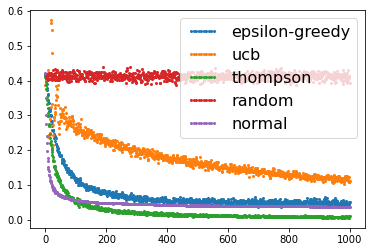

In [57]:

arm_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment_gaussian_added(arm_count)

We can observe the beta thompson converges better than gaussian thompson

#### Q7) What code is yours and what have you adapted?

The thomspon sampling, UCB , Epsilon Greedy and Random Sampling i have referred from Reference 1. The Thompson sampling for normal i have referenced reference 3 and wrote my code.

All Experiments were modified and done according to question

#### References:

https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb

https://en.m.wikipedia.org/wiki/Conjugate_prior

https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance

#### Q8) Did I explain my licensing clearly?

Copyright and Licensing
BSD 3-Clause License

Copyright (c) 2021, Prasanth Dwadasi All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [61]:
# Copyright (c) Prasanth Dwadasi
# Distributed under the terms of the 3-Clause BSD License.

You are free to use or adapt this notebook for any purpose you'd like. However, please respect the [Modified BSD License](https://jupyter.org/governance/projectlicense.html) that governs its use.